In [74]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pre-trained-transformer/pre-trained model with 64 classes-model_epoch_70.pt
/kaggle/input/pre-trained-transformer/ssl-padded_matrix_file.csv


In [75]:
from sklearn.metrics import accuracy_score,silhouette_score 
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import csv
import ast
import torch.nn.functional as F
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder
import random
from torch.optim import Adam
from torch.nn.functional import cross_entropy
import pandas as pd
from sklearn.model_selection import train_test_split

# select n-way-k-shot data

In [76]:
#Get 10 classses

#Get all skeleton locations into a single cell

import csv

def SelectClasses(selected_classes):
    # Specify the input and output file paths
    input_path = '/kaggle/input/pre-trained-transformer/ssl-padded_matrix_file.csv'
    output_path = '/kaggle/working/ssl-selected_classes.csv'
    
    # Open the input CSV file and the output CSV file
    with open(input_path, 'r') as input_file, open(output_path, 'w', newline='') as output_file:

        # Create a CSV reader object and a CSV writer object
        reader = csv.reader(input_file)
        writer = csv.writer(output_file)

        # Iterate over each row in the input CSV file
        for row in reader:

            clss = row[-1]
            
            if (int(clss) in selected_classes):
#                 print("clss",clss)
                row = row[:-1] + [clss]
#                 print(row)
                writer.writerow(row)


In [77]:
import csv


def extract_rows_by_label(rows_per_label):
    # initialize a dictionary to hold the rows for each label
    label_rows = {}
    
    input_file_path = "/kaggle/working/ssl-selected_classes.csv"
    output_file_path_train = "/kaggle/working/ssl-n-way-k-shot_train.csv"
    output_file_path_test = "/kaggle/working/ssl-n-way-k-shot_test.csv"


    # open the input file and read its contents
    with open(input_file_path, 'r') as file:
        csv_reader = csv.reader(file)
        for row in csv_reader:
            # extract the label from the end of the row
            label = row[-1]
            
            # add the row to the label's list in the dictionary
            if label in label_rows:
                label_rows[label].append(row)
            else:
                label_rows[label] = [row]

    # loop through the labels and write the output rows to a single file
    #train
    with open(output_file_path_train, 'w', newline='') as file:
        csv_writer = csv.writer(file)
        for label, rows in label_rows.items():
            # extract the first N rows for the label
            rows_to_write = rows[:rows_per_label]
            
            # write each row to the output file with the label appended
            for row in rows_to_write:
                csv_writer.writerow(row)

    #test
    with open(output_file_path_test, 'w', newline='') as file:
        csv_writer = csv.writer(file)
        for label, rows in label_rows.items():
            # extract the first N rows for the label
            rows_to_write = rows[-rows_per_label:]

            # write each row to the output file with the label appended
            for row in rows_to_write:
                csv_writer.writerow(row)

In [78]:
import random


def GenerateClasses(nb_of_classes, starting_number, ending_number):
    selected_classes = random.sample(range(starting_number, ending_number), nb_of_classes)

    # [0,1,3,4,5,30,31,33,34,35]
    print("classes: ",selected_classes)
    print("number of classes: ",len(selected_classes))
    
    return selected_classes


In [79]:
# selected_classes = GenerateClasses(14,50,64)    # ( nb_of_classes, starting_number, ending_number )

# selected_classes = [0,1,3,4,5,30,31,33,34,35]

selected_classes = [i for i in range(25)]

SelectClasses(selected_classes)

extract_rows_by_label(10)   # k shot x 2


# prototypical network

In [80]:
# Your code for loading the data (unchanged)
input_file = "/kaggle/working/ssl-n-way-k-shot_train.csv"

values = []
matrix_labels = []
num_rows = 0

with open(input_file, "r") as f_input:
    reader = csv.reader(f_input)
    for row in reader:
        row_values = []
        for i in range(len(row) - 1):
            column_value = ast.literal_eval(row[i])
            row_values.append(column_value)
        values.append(torch.tensor(row_values))
        matrix_labels.append(ast.literal_eval(row[-1]))
        num_rows += 1
        
matrix_labels = np.array(matrix_labels)

In [81]:
class TransformerEncoder(nn.Module):
    def __init__(self, n_features, d_model=32, nhead=32, num_layers=1):
        super(TransformerEncoder, self).__init__()
        self.embedding = nn.Linear(n_features, d_model)
        self.positional_encoding = self.generate_positional_encoding(d_model)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model, nhead), num_layers
        )

    def generate_positional_encoding(self, d_model, max_len=257):
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)

    def forward(self, x):
        x = self.embedding(x)
        x = x + self.positional_encoding[:, : x.size(1)]
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        return x

In [82]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )
#         print(z_proto.shape)
#         print(z_query.shape, z_proto.shape)
        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)
#         print(dists.shape)
        scores = -dists
        return scores
    
    def infer(self, input_data):
        # Ensure the model is in evaluation mode
        self.eval()

        # Convert the input data to a PyTorch tensor
        input_tensor = torch.tensor(input_data, dtype=torch.float32)

        # Forward pass through the model
        with torch.no_grad():
            embeddings = self.backbone.forward(input_tensor)

        return embeddings


In [83]:
# Load the data and split it into training and testing sets
# train_values, test_values, train_matrix_labels, test_matrix_labels = train_test_split(values, matrix_labels, test_size=0.2, random_state=42, stratify=matrix_labels)

train_values = torch.stack([torch.tensor(value) for value in values])
train_matrix_labels = matrix_labels

/tmp/ipykernel_42/2275156144.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [84]:
# Load the saved TransformerEncoder model
saved_model_path = "/kaggle/input/pre-trained-transformer/pre-trained model with 64 classes-model_epoch_70.pt"

checkpoint = torch.load(saved_model_path)
unexpected_keys = ["classification_head.weight", "classification_head.bias"]
for key in unexpected_keys:
    del checkpoint[key]

# Instantiate the TransformerEncoder as the backbone
n_features = 114
encoder = TransformerEncoder(n_features=n_features)
encoder.load_state_dict(checkpoint)

<All keys matched successfully>

In [85]:
model = PrototypicalNetworks(encoder)

In [86]:
def create_few_shot_task(embeddings, labels, n_way, k_shot, n_query):
    unique_labels = np.unique(labels)
    selected_labels = np.random.choice(unique_labels, n_way, replace=False)
#     print("selected",selected_labels)
    # Create a dictionary for mapping the original labels to the new labels
    label_map = {label: idx for idx, label in enumerate(selected_labels)}
#     print(label_map)
    support_set = []
    query_set = []
    support_labels = []
    query_labels = []

    for label in selected_labels:
        class_embeddings = embeddings[labels == label]
#         print(len(class_embeddings))
        if len(class_embeddings) < k_shot + n_query:
            continue
        support_indices = np.random.choice(range(len(class_embeddings)), k_shot, replace=False)
        query_indices = np.random.choice(np.delete(range(len(class_embeddings)), support_indices), n_query, replace=False)
        
        support_set.append(class_embeddings[support_indices].detach().numpy())
        query_set.append(class_embeddings[query_indices].detach().numpy())
        support_labels.extend([label_map[label]] * k_shot)
        query_labels.extend([label_map[label]] * n_query)
#     print(np.unique(support_labels))
    support_set = np.concatenate(support_set, axis=0)
    query_set = np.concatenate(query_set, axis=0)
    support_labels = np.array(support_labels)
    query_labels = np.array(query_labels)
    
    return support_set, query_set, support_labels, query_labels


In [87]:
# Training parameters
n_epochs = 100
n_way = 5
k_shot = 5
n_query = 5
lr = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(n_epochs):
    print(f"Epoch: {epoch + 1}/{n_epochs}")
#     print(np.unique(train_matrix_labels))
    support_set, query_set, support_labels, query_labels = create_few_shot_task(train_values, np.array(train_matrix_labels), n_way, k_shot, n_query)
    support_set = torch.tensor(support_set, dtype=torch.float32)
    query_set = torch.tensor(query_set, dtype=torch.float32)
    support_labels = torch.tensor(support_labels, dtype=torch.long)
    model.train()
    optimizer.zero_grad()
#     print(support_set)
    scores = model(support_set, support_labels, query_set)
    loss = criterion(scores, torch.tensor(query_labels, dtype=torch.long))

    loss.backward()
    optimizer.step()
#     print(scores)
    # Compute accuracy
    _, predictions = torch.max(scores, 1)
#     print(predictions)
#     print(query_labels)
    accuracy = accuracy_score(query_labels, predictions.detach().numpy())
    
    # Calculate Silhouette Coefficient
    with torch.no_grad():
        query_embeddings = model.backbone.forward(query_set)
    silhouette_coefficient = silhouette_score(query_embeddings.detach().numpy(), query_labels)

#     print(f"Loss: {loss.item()}, Accuracy: {accuracy * 100}%")
    print(f"Loss: {loss.item()}, Accuracy: {accuracy * 100}%, Silhouette Coefficient: {silhouette_coefficient}")

Epoch: 1/100
Loss: 1.1974278688430786, Accuracy: 52.0%, Silhouette Coefficient: 0.018569687381386757
Epoch: 2/100
Loss: 1.2913609743118286, Accuracy: 44.0%, Silhouette Coefficient: 0.007703843060880899
Epoch: 3/100
Loss: 1.1742069721221924, Accuracy: 48.0%, Silhouette Coefficient: -0.004876680206507444
Epoch: 4/100
Loss: 1.3862965106964111, Accuracy: 44.0%, Silhouette Coefficient: -0.06677599251270294
Epoch: 5/100
Loss: 0.847035825252533, Accuracy: 76.0%, Silhouette Coefficient: 0.0718090832233429
Epoch: 6/100
Loss: 1.139211654663086, Accuracy: 56.00000000000001%, Silhouette Coefficient: 0.05087411031126976
Epoch: 7/100
Loss: 0.838938295841217, Accuracy: 72.0%, Silhouette Coefficient: 0.056120242923498154
Epoch: 8/100
Loss: 0.9372296333312988, Accuracy: 68.0%, Silhouette Coefficient: 0.10522790253162384
Epoch: 9/100
Loss: 0.9939372539520264, Accuracy: 56.00000000000001%, Silhouette Coefficient: 0.023306889459490776
Epoch: 10/100
Loss: 0.8622175455093384, Accuracy: 76.0%, Silhouette Coe

# testing

In [96]:
# Your code for loading the data (unchanged)
input_file = "/kaggle/working/ssl-n-way-k-shot_train.csv"

values = []
matrix_labels = []
num_rows = 0

with open(input_file, "r") as f_input:
    reader = csv.reader(f_input)
    for row in reader:
        row_values = []
        for i in range(len(row) - 1):
            column_value = ast.literal_eval(row[i])
            row_values.append(column_value)
        values.append(torch.tensor(row_values))
        matrix_labels.append(ast.literal_eval(row[-1]))
        num_rows += 1
        
matrix_labels = np.array(matrix_labels)

In [97]:
test_values = torch.stack([torch.tensor(value) for value in values])
test_matrix_labels = matrix_labels

/tmp/ipykernel_42/4049386236.py:1: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [98]:
def create_few_shot_task_with_and_without_label_map(embeddings, labels, n_way, k_shot, n_query):
    
    unique_labels = np.unique(labels)
    selected_labels = np.random.choice(unique_labels, n_way, replace=False)
    # Create a dictionary for mapping the original labels to the new labels
    label_map = {label: idx for idx, label in enumerate(selected_labels)}
    support_set = []
    query_set = []
    support_labels = []
    unmapped_support_labels = []
    query_labels = []
    unmapped_query_labels = []

    for label in selected_labels:
        class_embeddings = embeddings[labels == label]
        if len(class_embeddings) < k_shot + n_query:
            continue
        support_indices = np.random.choice(range(len(class_embeddings)), k_shot, replace=False)
        query_indices = np.random.choice(np.delete(range(len(class_embeddings)), support_indices), n_query, replace=False)
        
        support_set.append(class_embeddings[support_indices].detach().numpy())
        query_set.append(class_embeddings[query_indices].detach().numpy())
        support_labels.extend([label_map[label]] * k_shot)
        unmapped_support_labels.extend([label] * k_shot)
        query_labels.extend([label_map[label]] * n_query)
        unmapped_query_labels.extend([label] * n_query)

#     print('support labels', unmapped_support_labels, set(unmapped_support_labels))
    support_set = np.concatenate(support_set, axis=0)
    query_set = np.concatenate(query_set, axis=0)
    support_labels = np.array(support_labels)
    query_labels = np.array(query_labels)
    
    unmapped_support_labels = np.array(unmapped_support_labels)
    unmapped_query_labels = np.array(unmapped_query_labels)
    
    return support_set, query_set, support_labels, query_labels, unmapped_support_labels, unmapped_query_labels


In [99]:
prototypes = {}
pros_embeddings = []
pros_labels = []
su = []
prototypes_repetition= {}
def collect_prototypes(support_set,query_set, support_labels, n_way, k_shot):
    support_embeddings = model.backbone(support_set)
    z_proto = []
    unique_labels = np.unique(np.array(support_labels))
    unique_labels, indices = np.unique(support_labels, return_index=True)

    # Get the unique labels in their original order
    unique_labels_in_original_order = unique_labels[np.argsort(indices)]
    for label in unique_labels_in_original_order:
        proto = support_embeddings[torch.nonzero(support_labels == label)].mean(0)
        z_proto.append(proto)

    z_proto = torch.stack(z_proto)
    prototype_embeddings = z_proto.detach().numpy()
    
    for i in range(len(unique_labels_in_original_order)):
        pros_embeddings.append(prototype_embeddings[i][0])
        pros_labels.append(unique_labels_in_original_order[i].item())
        prototypes[unique_labels_in_original_order[i].item()] =  list(prototype_embeddings[i])

In [100]:
# Set the number of evaluation episodes
n_evaluation_episodes = 100

# Initialize the accuracy accumulator
total_accuracy = 0

# Set the model to evaluation mode
model.eval()

# Evaluation loop
for episode in range(n_evaluation_episodes): 
    support_set, query_set, support_labels, query_labels, unmapped_support_labels, unmapped_query_labels = create_few_shot_task_with_and_without_label_map(test_values, np.array(test_matrix_labels), n_way, k_shot, n_query)
    support_set = torch.tensor(support_set, dtype=torch.float32)
    query_set = torch.tensor(query_set, dtype=torch.float32)
    support_labels = torch.tensor(support_labels, dtype=torch.long)
    unmapped_support_labels = torch.tensor(unmapped_support_labels, dtype=torch.long) 

    collect_prototypes(support_set, query_set,unmapped_support_labels, n_way, k_shot )
    with torch.no_grad():
        scores = model(support_set, support_labels, query_set)
#         print(scores.shape)
#         print(scores)
        # Compute accuracy
        _, predictions = torch.max(scores, 1)
#         print(predictions.detach().numpy())
#         print(query_labels)
        accuracy = accuracy_score(query_labels, predictions.detach().numpy())
#         print(accuracy)
        # Calculate Silhouette Coefficient
        with torch.no_grad():
            query_embeddings = model.backbone.forward(query_set)
            silhouette_coefficient = silhouette_score(query_embeddings.detach().numpy(), query_labels)
        total_accuracy += accuracy
#         print("Accuracy: {:.2%}, Silhouette Coefficient: {:.2f}".format(accuracy, silhouette_coefficient))

# Compute the average accuracy over all evaluation episodes
average_accuracy = total_accuracy / n_evaluation_episodes
# print(f"Average accuracy: {average_accuracy * 100}%")

support labels [25, 25, 25, 25, 25, 45, 45, 45, 45, 45, 26, 26, 26, 26, 26, 47, 47, 47, 47, 47, 49, 49, 49, 49, 49] {45, 47, 49, 25, 26}
support labels [28, 28, 28, 28, 28, 37, 37, 37, 37, 37, 38, 38, 38, 38, 38, 45, 45, 45, 45, 45, 36, 36, 36, 36, 36] {36, 37, 38, 45, 28}
support labels [25, 25, 25, 25, 25, 31, 31, 31, 31, 31, 41, 41, 41, 41, 41, 26, 26, 26, 26, 26, 49, 49, 49, 49, 49] {41, 49, 25, 26, 31}
support labels [46, 46, 46, 46, 46, 34, 34, 34, 34, 34, 39, 39, 39, 39, 39, 43, 43, 43, 43, 43, 40, 40, 40, 40, 40] {34, 39, 40, 43, 46}
support labels [46, 46, 46, 46, 46, 31, 31, 31, 31, 31, 40, 40, 40, 40, 40, 35, 35, 35, 35, 35, 44, 44, 44, 44, 44] {35, 40, 44, 46, 31}
support labels [36, 36, 36, 36, 36, 25, 25, 25, 25, 25, 42, 42, 42, 42, 42, 46, 46, 46, 46, 46, 39, 39, 39, 39, 39] {36, 39, 42, 46, 25}
support labels [43, 43, 43, 43, 43, 28, 28, 28, 28, 28, 45, 45, 45, 45, 45, 27, 27, 27, 27, 27, 35, 35, 35, 35, 35] {35, 43, 45, 27, 28}
support labels [27, 27, 27, 27, 27, 44, 4

In [101]:
import plotly.express as px
import plotly.colors as colors
from itertools import cycle
from sklearn.preprocessing import LabelEncoder

tsne = TSNE(n_components=2, random_state=42)  
test_embeddings_2d = tsne.fit_transform(torch.tensor(pros_embeddings)) 

le = LabelEncoder()
test_labels_int = le.fit_transform(torch.tensor(pros_labels))

n_classes = 25 ##================================================CLASSES
color_scale = cycle(colors.qualitative.Plotly)

fig = go.Figure()
for i in range(n_classes):
    class_mask = test_labels_int == i
    fig.add_trace(
        go.Scatter(
            x=test_embeddings_2d[class_mask, 0],  
            y=test_embeddings_2d[class_mask, 1],  
            mode="markers",
            name=str(le.inverse_transform([i])[0]),
            marker=dict(size=3, color=next(color_scale)),
        ),
    )

fig.update_layout(height=600, width=800, title_text="Embeddings Visualizations (2D)")
fig.show()

In [102]:
def visualize_embeddings(embeddings, labels, markers, title):
    # Apply t-SNE for dimensionality reduction to 2D
    tsne = TSNE(n_components=2)
    embeddings_tsne = tsne.fit_transform(embeddings)
    
    # Set up the figure for plotting
    fig, ax = plt.subplots(figsize=(8, 8))

    # Set up the color map (one color per class)
    cmap = plt.cm.get_cmap('viridis', len(np.unique(labels)))

    # Create an empty list to store legend handles
    legend_handles = []

    # Iterate through the unique labels to create a legend handle for each class
    for label in np.unique(labels):
        legend_handles.append(
            plt.Line2D(
                [0],
                [0],
                marker='o',
                color=cmap(label),
                label=f'Class {label}',
                markerfacecolor=cmap(label),
                markersize=8,
                linestyle='None'
            )
        )

    # Add the legend for the classes
    ax.legend(handles=legend_handles, loc='upper left', title='Classes')

    for idx, (embedding, label, marker) in enumerate(zip(embeddings_tsne, labels, markers)):
        ax.scatter(*embedding, c=[cmap(label)], marker=marker, s=100)

    # Add a legend for the marker types
    support_marker = plt.Line2D([], [], color='k', marker='o', linestyle='None', markersize=10, label='Support Set')
    query_marker = plt.Line2D([], [], color='k', marker='*', linestyle='None', markersize=10, label='Query Set')
    prototype_marker = plt.Line2D([], [], color='k', marker='x', linestyle='None', markersize=10, label='Prototypes')

    ax.legend(handles=[support_marker, query_marker, prototype_marker], loc='upper right', title='Marker Types')

    # Configure plot appearance
    ax.set_title(title)
    ax.set_xlabel("t-SNE 1")
    ax.set_ylabel("t-SNE 2")
    plt.show()



/tmp/ipykernel_42/2841811915.py:10: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



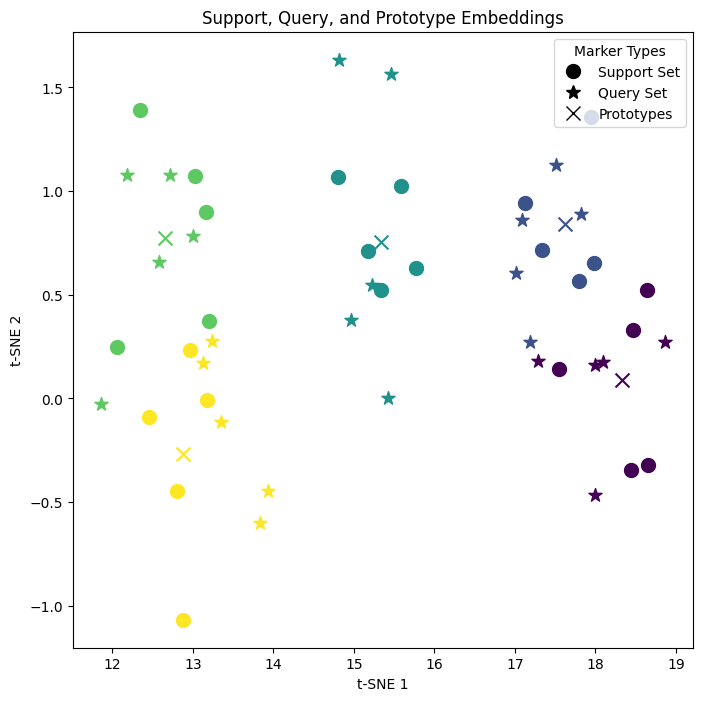

In [103]:
support_set, query_set, support_labels, query_labels = create_few_shot_task(test_values, np.array(test_matrix_labels), n_way, k_shot, 5)
support_set = torch.tensor(support_set, dtype=torch.float32)
query_set = torch.tensor(query_set, dtype=torch.float32)
support_labels = torch.tensor(support_labels, dtype=torch.long) 


# Extract embeddings and labels for support set, query set, and prototypes
support_embeddings = model.backbone(support_set)

z_proto = torch.cat(
            [
                support_embeddings[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

support_embeddings = support_embeddings.detach().numpy()
query_embeddings = model.backbone(query_set).detach().numpy()
prototype_embeddings = z_proto.detach().numpy()

# Create markers for support set ('o'), query set ('*'), and prototypes ('x')
support_markers = ['o'] * len(support_labels)
query_markers = ['*'] * len(query_labels)
prototype_markers = ['x'] * len(np.unique(support_labels))

# Concatenate support, query, and prototype data
all_embeddings = np.concatenate([support_embeddings, query_embeddings, prototype_embeddings], axis=0)
all_labels = np.concatenate([support_labels, query_labels, np.unique(support_labels)], axis=0)
all_markers = support_markers + query_markers + prototype_markers

# Visualize the embeddings
visualize_embeddings(all_embeddings, all_labels, all_markers, "Support, Query, and Prototype Embeddings")

In [ ]:
# Convert the dictionary into a list of tuples
data_tuples = [(list(v[0]), k) for k, v in prototypes.items()]

# Convert the list of tuples into a DataFrame
df = pd.DataFrame(data_tuples, columns=['feature', 'label'])

# Save to CSV
df.to_csv('/kaggle/working/prototypes_1.csv')

In [ ]:
torch.save(encoder.state_dict(), "/kaggle/working/encoder_1.pt")

In [ ]:
# Save the model
torch.save(model.state_dict(), "/kaggle/working/prototypicalNetwork_1.pt")